In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import math
import gurobipy as gb

In [2]:
from customer import Customer
from locker_customer import LockerCustomer
from door_to_door_customer import DoorToDoorCustomer
from location import Location
from store import *
from vehicle import Vehicle
from vehicle_type import VehicleType

In [3]:
# input
custom_setup = False
C = 15
L = 3

map_size = 100
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [4]:
def get_nearest_store(stores, location):
    min_distance = float("inf")
    nearest_store = stores[0]
    for store in stores:
        distance = location.euclidean_distance(store.location)
        if distance < min_distance:
            min_distance = distance
            nearest_store = store
    return nearest_store

In [5]:
# generate data
if custom_setup:
    C = 8
    L = 2
    stores = []
    stores.append(Store(Location(60, 50), capacity=float("inf"), is_warehouse=True))
    stores.append(Store(Location(30, 50), capacity=math.ceil(0.8 * C / L)))
    stores.append(Store(Location(50, 20), capacity=math.ceil(0.8 * C / L)))

    customers = []
    customers.append(LockerCustomer(Location(10, 28), stores[1]))
    customers.append(DoorToDoorCustomer(Location(20, 40), prime=False))
    customers.append(DoorToDoorCustomer(Location(15, 70), prime=False))
    customers.append(DoorToDoorCustomer(Location(30, 70), prime=True))
    customers.append(DoorToDoorCustomer(Location(80, 60), prime=True))
    customers.append(LockerCustomer(Location(70, 40), stores[0]))
    customers.append(DoorToDoorCustomer(Location(90, 50), prime=False))
    customers.append(LockerCustomer(Location(40, 15), stores[2]))
else:
    stores = []
    stores.append(Store(Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=float("inf")))
    for l in range(L):
        stores.append(Store(Location(random.randint(0, map_size), random.randint(0, map_size)), capacity=math.ceil(0.8 * C / L)))

    customers = []
    for c in range(C):
        location = Location(random.randint(0, map_size), random.randint(0, map_size))
        if random.random() < ratio_locker_customers:
            customers.append(LockerCustomer(location, get_nearest_store(stores, location)))
        else:
            if random.random() < ratio_prime_door_to_door_customer:
                customers.append(DoorToDoorCustomer(location, prime=True))
            else:
                customers.append(DoorToDoorCustomer(location, prime=False))

In [6]:
# create sets
C_L = list(filter(lambda customer: type(customer) == LockerCustomer, customers))
C_D = list(filter(lambda customer: type(customer) == DoorToDoorCustomer, customers))
S_k = list(filter(lambda customer: type(customer) == DoorToDoorCustomer and customer.prime == False, customers))
lockers = list(filter(lambda store: not store.is_warehouse, stores))

sum_W_l = 0
for store in stores:
    if not store.is_warehouse:
        sum_W_l += store.capacity

# define all the vehicles
if custom_setup:
    vehicles = []
    vehicles.append(Vehicle(VehicleType.LOCKER_SUPPLY, stores[0], math.ceil(0.8 * sum_W_l)))
    vehicles.append(Vehicle(VehicleType.PF, stores[0], math.ceil(0.5 * len(C_D))))
    vehicles.append(Vehicle(VehicleType.LF, stores[1], math.ceil(0.6 * stores[1].capacity)))
    vehicles.append(Vehicle(VehicleType.LF, stores[2], math.ceil(0.6 * stores[2].capacity)))
else:
    vehicles = []
    for store in stores:
        if store.is_warehouse:
            vehicles.append(Vehicle(VehicleType.LOCKER_SUPPLY, store, math.ceil(0.8 * sum_W_l)))
            vehicles.append(Vehicle(VehicleType.PF, store, math.ceil(0.5 * len(C_D))))
        else:
            vehicles.append(Vehicle(VehicleType.LF, store, math.ceil(0.6 * store.capacity)))

In [7]:
# define some np.array to plot the map
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])
S_k_location = np.array([[0,0]])
L_location = np.array([[0,0]])
W_location = np.array([[0,0]])

for store in stores:
    if store.is_warehouse:
        W_location = np.vstack([W_location, [store.location.x, store.location.y]])
    else:
        L_location = np.vstack([L_location, [store.location.x, store.location.y]])
for cd in C_D:
    CD_location = np.vstack([CD_location, [cd.location.x, cd.location.y]])
for cl in C_L:
    CL_location = np.vstack([CL_location, [cl.location.x, cl.location.y]])
for sk in S_k:
    S_k_location = np.vstack([S_k_location, [sk.location.x, sk.location.y]])

S_k_location = np.delete(S_k_location,0,0)
CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)
L_location = np.delete(L_location, 0, 0)
W_location = np.delete(W_location, 0, 0)

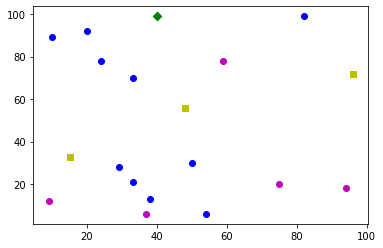

In [8]:
# plot the map
plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

In [9]:
#calcolo la matrice delle distanze:

all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + C_D + C_L

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)


             W         L1          L2         L3         CD0         CD1  \
W     0.000000  70.576200   62.169124  43.737855   21.189620   42.000000   
L1   70.576200   0.000000   89.899944  40.224371   59.211485   94.047860   
L2   62.169124  89.899944    0.000000  50.596443   78.587531   30.413813   
L3   43.737855  40.224371   50.596443   0.000000   45.607017   54.817880   
CD0  21.189620  59.211485   78.587531  45.607017    0.000000   62.393910   
CD1  42.000000  94.047860   30.413813  54.817880   62.393910    0.000000   
CD2  94.047860  47.434165   78.230429  50.358713   92.477024   97.123633   
CD3  86.023253  30.479501   82.734515  44.147480   81.024688   96.602277   
CD4  29.832868  41.146081   63.031738  20.518285   25.553865   56.938563   
CD5  31.622777  56.222771   87.664132  50.328918   10.440307   72.691127   
CD6  78.313473  21.633308   81.055537  38.078866   72.180330   92.114060   
CD7  26.400758  45.891176   72.249567  32.557641   14.560220   61.684682   
CD8  71.8470

In [10]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores, axis=1)
supply_distances_matrix = supply_distances_matrix.filter(items=stores, axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=[stores[0]] + C_D, axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=[stores[0]] + C_D, axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+C_D, axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers + C_D, axis=0)
print(LF_distances_matrix)

            W         L1         L2         L3
W    0.000000  70.576200  62.169124  43.737855
L1  70.576200   0.000000  89.899944  40.224371
L2  62.169124  89.899944   0.000000  50.596443
L3  43.737855  40.224371  50.596443   0.000000
             W        CD0        CD1        CD2        CD3        CD4  \
W     0.000000  21.189620  42.000000  94.047860  86.023253  29.832868   
CD0  21.189620   0.000000  62.393910  92.477024  81.024688  25.553865   
CD1  42.000000  62.393910   0.000000  97.123633  96.602277  56.938563   
CD2  94.047860  92.477024  97.123633   0.000000  17.464249  67.357256   
CD3  86.023253  81.024688  96.602277  17.464249   0.000000  57.218878   
CD4  29.832868  25.553865  56.938563  67.357256  57.218878   0.000000   
CD5  31.622777  10.440307  72.691127  93.941471  80.993827  29.832868   
CD6  78.313473  72.180330  92.114060  25.806976   9.433981  49.000000   
CD7  26.400758  14.560220  61.684682  78.000000  66.490601  12.041595   
CD8  71.847060  64.629715  88.60022

In [11]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75

PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)


            W         L1         L2         L3
W    0.000000  52.932150  46.626843  32.803392
L1  52.932150   0.000000  67.424958  30.168278
L2  46.626843  67.424958   0.000000  37.947332
L3  32.803392  30.168278  37.947332   0.000000
             W        CD0        CD1        CD2        CD3        CD4  \
W     0.000000  21.189620  42.000000  94.047860  86.023253  29.832868   
CD0  21.189620   0.000000  62.393910  92.477024  81.024688  25.553865   
CD1  42.000000  62.393910   0.000000  97.123633  96.602277  56.938563   
CD2  94.047860  92.477024  97.123633   0.000000  17.464249  67.357256   
CD3  86.023253  81.024688  96.602277  17.464249   0.000000  57.218878   
CD4  29.832868  25.553865  56.938563  67.357256  57.218878   0.000000   
CD5  31.622777  10.440307  72.691127  93.941471  80.993827  29.832868   
CD6  78.313473  72.180330  92.114060  25.806976   9.433981  49.000000   
CD7  26.400758  14.560220  61.684682  78.000000  66.490601  12.041595   
CD8  71.847060  64.629715  88.60022

In [12]:

LF_delivery_cost_multidim = np.zeros((L,len(C_D)+1,len(C_D)+1))

for i in range(L):
    l = [0]
    l[0]=lockers[i]
    ls = LF_delivery_cost.filter(items=l+C_D,axis=1)
    ls = ls.filter(items=l+C_D,axis=0)
    print(ls)
    lt = ls.to_numpy()
    for j in range(1+len(C_D)):
        for k in range(1+len(C_D)):
            LF_delivery_cost_multidim[i][j][k]=lt[j][k]


            L1        CD0        CD1        CD2        CD3        CD4  \
L1    0.000000  50.329763  79.940681  40.319040  25.907576  34.974169   
CD0  50.329763   0.000000  53.034823  78.605471  68.870984  21.720785   
CD1  79.940681  53.034823   0.000000  82.555088  82.111936  48.397779   
CD2  40.319040  78.605471  82.555088   0.000000  14.844612  57.253668   
CD3  25.907576  68.870984  82.111936  14.844612   0.000000  48.636046   
CD4  34.974169  21.720785  48.397779  57.253668  48.636046   0.000000   
CD5  47.789356   8.874261  61.787458  79.850250  68.844753  25.357938   
CD6  18.388312  61.353280  78.296951  21.935929   8.018884  41.650000   
CD7  39.007499  12.376187  52.431980  66.300000  56.517011  10.235355   
CD8  12.636158  54.935257  75.310192  28.306404  14.868927  35.861539   
CD9  29.859086  58.545196  64.650309  20.681393  17.687354  36.943233   

           CD5        CD6        CD7        CD8        CD9  
L1   47.789356  18.388312  39.007499  12.636158  29.859086  
C

In [13]:
#compensation

compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,S_k_location])

#define indexes for the subset S_k
S_k_indexes = []
for s in range(len(S_k_location)):
    S_k_indexes.append("Sk"+str(s))

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+S_k_indexes)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)

print(compensation_matrix)


distance_matrix_customer_locker_store = dist_matrix.filter(items=C_L,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)
print(distance_matrix_customer_locker_store)


closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print(closest_store_to_CL)

index_close_locker = []
for i in range(len(closest_store_to_CL)):
    index_close_locker.append(closest_store_to_CL[i])
print(index_close_locker)


# TODO matrix layout to reformat
d_ak_c = compensation_matrix.filter(items = S_k_indexes,axis=1)
d_ak_c=d_ak_c.filter(items=index_close_locker,axis=0)
print(d_ak_c)

ro = 0.5
compensation_matrix_cost = ro*d_ak_c
print(compensation_matrix_cost)
compensation_matrix_cost_multidim = compensation_matrix_cost.to_numpy()
print(compensation_matrix_cost_multidim)



             W         L1         L2         L3        Sk0        Sk1  \
W     0.000000  70.576200  62.169124  43.737855  94.047860  86.023253   
L1   70.576200   0.000000  89.899944  40.224371  47.434165  30.479501   
L2   62.169124  89.899944   0.000000  50.596443  78.230429  82.734515   
L3   43.737855  40.224371  50.596443   0.000000  50.358713  44.147480   
Sk0  94.047860  47.434165  78.230429  50.358713   0.000000  17.464249   
Sk1  86.023253  30.479501  82.734515  44.147480  17.464249   0.000000   
Sk2  31.622777  56.222771  87.664132  50.328918  93.941471  80.993827   
Sk3  78.313473  21.633308  81.055537  38.078866  25.806976   9.433981   
Sk4  26.400758  45.891176  72.249567  32.557641  78.000000  66.490601   
Sk5  69.720872  35.128336  62.289646  26.076810  24.331050  20.808652   

           Sk2        Sk3        Sk4        Sk5  
W    31.622777  78.313473  26.400758  69.720872  
L1   56.222771  21.633308  45.891176  35.128336  
L2   87.664132  81.055537  72.249567  62.28964

In [14]:
for s in stores:
    print(s.find_associated_CL(customers, stores))


[]
[CL1, CL4]
[CL3]
[CL0, CL2]


In [15]:
'''
def find_closest_Cl_to_locker(i):
    only_cl_close_to_l_i=[]
    counter = 0
    for j in range(len(index_close_locker)):
        if lockers[i] == index_close_locker[j]:
            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)
            counter = counter+1
    #only_cl_close_to_l_i = only_cl_close_to_l_i.astype(int)
    return only_cl_close_to_l_i

def find_q_array_for_closest_cl_to_locker(i):
    q_cl_close_to_locker_i=[]
    only_cl_close_to_l_i=[]
    counter = 0
    for j in range(len(index_close_locker)):
        if lockers[i] == index_close_locker[j]:
            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)
            counter = counter+1

    q_cl_close_to_locker_i = np.ones(counter)
    q_cl_close_to_locker_i=q_cl_close_to_locker_i.astype(int)
    return q_cl_close_to_locker_i
'''

'\ndef find_closest_Cl_to_locker(i):\n    only_cl_close_to_l_i=[]\n    counter = 0\n    for j in range(len(index_close_locker)):\n        if lockers[i] == index_close_locker[j]:\n            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)\n            counter = counter+1\n    #only_cl_close_to_l_i = only_cl_close_to_l_i.astype(int)\n    return only_cl_close_to_l_i\n\ndef find_q_array_for_closest_cl_to_locker(i):\n    q_cl_close_to_locker_i=[]\n    only_cl_close_to_l_i=[]\n    counter = 0\n    for j in range(len(index_close_locker)):\n        if lockers[i] == index_close_locker[j]:\n            only_cl_close_to_l_i=np.append(only_cl_close_to_l_i, j)\n            counter = counter+1\n\n    q_cl_close_to_locker_i = np.ones(counter)\n    q_cl_close_to_locker_i=q_cl_close_to_locker_i.astype(int)\n    return q_cl_close_to_locker_i\n'

In [16]:
col_ind = []
d_ak_k=[]
index_close_locker = []
min_value = []
Sk_def=[]
OC = []
position_sk = []
position_cl = []
pck = np.array([])
locker_where_oc_goes=[]
#compensation
compensation_locations = np.array([])
compensation_locations = np.append(compensation_locations,W_location)
compensation_locations = np.vstack([compensation_locations,L_location])
compensation_locations = np.vstack([compensation_locations,CD_location])

df_compensation = pd.DataFrame(compensation_locations, columns=['xcord', 'ycord'], index=stores+C_D)
compensation_matrix= pd.DataFrame(distance_matrix(df_compensation.values, df_compensation.values), index=df_compensation.index, columns=df_compensation.index)


distance_matrix_customer_locker_store = dist_matrix.filter(items=C_L,axis=1)
distance_matrix_customer_locker_store = distance_matrix_customer_locker_store.filter(items=stores,axis=0)



closest_store_to_CL = distance_matrix_customer_locker_store.idxmin()
print("-------distance_matrix_customer_locker_store----------")
print(distance_matrix_customer_locker_store)
print("----------distance_matrix_customer_locker_store.idxmin()-------------------")
print(distance_matrix_customer_locker_store.idxmin())


min_value_col = distance_matrix_customer_locker_store.min()
print("-----------min_value_col------------")
print(min_value_col)

for i in range(len(closest_store_to_CL)):
    index_close_locker.append(str(closest_store_to_CL[i]))
    min_value.append(min_value_col[i])
print("-----------index_close_locker----------")
print(index_close_locker)
print("----------min_value----------------")
print(min_value)


print("index_close_locker-----------------------------")
print(index_close_locker)
print("compensation_matrix-------------------------------")
print(compensation_matrix)
#d_ak_c=d_ak_c.filter(items=C_D,axis=0)
#print("--------------d_ak_c----------------")
#print(d_ak_c)

for i in range(len(C_L)):
    col_ind.append("D_"+str(index_close_locker[i])+"_"+str(C_L[i].index))
print(col_ind)

d_ak_k = pd.DataFrame(min_value, index=col_ind)
print(d_ak_k)

pre_d_c_k = dist_matrix.filter(items=C_D,axis=0)
pre_d_c_k = pre_d_c_k.filter(items=C_L,axis=1)
print("--------pre_d_c_k-----------------------")
print(pre_d_c_k)

d_ak_c = pd.DataFrame()

# insert d_c_k
for cl in C_L:
    # Using DataFrame.insert() to add a column
    store = cl.store
    array = []
    for cd in C_D:
        distance = store.location.euclidean_distance(cd.location)
        array.append(distance)
    d_ak_c.insert(len(d_ak_c.columns), store, array, True)


print("-------------- d_ak_c after insertion -------------------")
print(d_ak_c)


d_c_k = dist_matrix.filter(items=C_D,axis=0)
d_c_k = d_c_k.filter(items=C_L,axis=1)

print("-------------- d_c_k after filter -------------------")
print(d_c_k)

print("===========d_ak_c==============")
print(d_ak_c)
print("=============d_c_k============")
print(d_c_k)
print("=========================")

sum_dck_dakc = d_ak_c.to_numpy()+d_c_k.to_numpy()
print("--------------sum_dck_dakc--------------------")
print(sum_dck_dakc)

def find_Sk(cd,cl):
    S_K_i = []
    if sum_dck_dakc[cl][cd]<=1.5*d_ak_k.to_numpy()[cl]:
        S_K_i.append('Cd'+str(cd))
    return S_K_i
print(find_Sk(0,0))

for cl in range(len(C_L)):
    for cd in range(len(C_D)):
        if sum_dck_dakc[cd][cl]<=1.5*d_ak_k.to_numpy()[cl]:
            OC.append('Cl'+str(cl))
            Sk_def.append('Cd'+str(cd))
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl]))

'''
for cl in C_L:
    for cd in C_D:
        if sum_dck_dakc[cd.door_to_door_customer_index][cl.locker_customer_index]<=1.5*d_ak_k.to_numpy()[cl.locker_customer_index]:
            OC.append(cl)
            Sk_def.append(cd)
            position_sk.append(cd)
            position_cl.append(cl)
            locker_where_oc_goes.append((index_close_locker[cl.locker_customer_index]))
'''

print(Sk_def)
print(OC)
print(locker_where_oc_goes)
print(position_cl)
print(position_sk)
def unique(list1):
    # initialize a null list
    unique_list = []
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

OC_unique = unique(OC)
print(OC_unique)
Sk = unique(Sk_def)
Sk=sorted(Sk, key=lambda x: int("".join([i for i in x if i.isdigit()])))
print(Sk)



index_of_cl_associated_to_closest_locker =[]
for i in range(len(OC_unique)):
    index_of_cl_associated_to_closest_locker.append(OC_unique[i]+'->'+index_close_locker[i])
print(index_of_cl_associated_to_closest_locker)


big_matrix= np.zeros((len(C_D),len(C_L)))
big_matrix=pd.DataFrame(big_matrix, index=C_D, columns=C_L)

for i in range(len(position_sk)):
    big_matrix.values[position_sk[i]][position_cl[i]]=d_ak_c.values[position_sk[i]][position_cl[i]]

print("-------big_matrix-----------")
print(big_matrix)

print("------ OC_unique .......")
print(OC_unique)

OC = []
for i in C_L:
    is_all_null = True
    for j in range(len(C_D)):
        if big_matrix.values[j][i.locker_customer_index] != 0:
            is_all_null = False
            OC.append(i)
    if is_all_null:
        print(i)
        #print(i.locker_customer_index)

print(big_matrix)

OC = list(set(OC))

print("OC test: ", OC)



d_cd_oc=big_matrix.filter(items=OC,axis=1)

pippo = []
for cd in C_D:
    for s in range(len(position_sk)):
        if cd.door_to_door_customer_index == position_sk[s]:
            pippo.append(cd)
print("pippo: ", pippo)


d_ak_c=d_cd_oc.filter(items=pippo,axis=0)

print("----------d_ak_c before index_of_cl_associated_to_closest_locker----------")
print(d_ak_c)
d_ak_c.columns= index_of_cl_associated_to_closest_locker
print("----------d_ak_c after index_of_cl_associated_to_closest_locker----------")
print(d_ak_c)


d_ak_c = d_ak_c.to_numpy()
pck = 0.5*d_ak_c

print("--------pck before for ----------")
print(pck)


for c in range(len(Sk)):
    for k in range(len(OC_unique)):
        if pck[c][k]==0:
            pck[c][k]=100000
print("-----------pck------------")
print(pck)


-------distance_matrix_customer_locker_store----------
          CL0         CL1        CL2        CL3        CL4
W   86.406018   92.357999  28.319605  97.349884  93.048375
L1  61.392182   21.840330  62.936476  80.411442  34.828150
L2  56.080300  105.683490  37.483330  54.037024  88.526832
L3  45.000000   58.796258  24.596748  59.665736  51.195703
----------distance_matrix_customer_locker_store.idxmin()-------------------
CL0    L3
CL1    L1
CL2    L3
CL3    L2
CL4    L1
dtype: object
-----------min_value_col------------
CL0    45.000000
CL1    21.840330
CL2    24.596748
CL3    54.037024
CL4    34.828150
dtype: float64
-----------index_close_locker----------
['L3', 'L1', 'L3', 'L2', 'L1']
----------min_value----------------
[45.0, 21.840329667841555, 24.596747752497688, 54.037024344425184, 34.828149534535996]
index_close_locker-----------------------------
['L3', 'L1', 'L3', 'L2', 'L1']
compensation_matrix-------------------------------
             W         L1         L2         L3  

In [20]:
single_period_problem =gb.Model()
single_period_problem.modelSense = gb.GRB.MINIMIZE #declare mimization


In [21]:
I_PF = 1 + len(C_D)
J_PF = 1 + len(C_D)

I_L = 1 + L
J_L = 1 + L

I_LF = 1 + len(C_D)
J_LF = 1 + len(C_D)

# add var to the problem
x_i_j   =   single_period_problem.addVars([(i, j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.BINARY)
x_i_j_L =   single_period_problem.addVars([(i, j) for i in range(I_L) for j in range(J_L) ], vtype=gb.GRB.BINARY)
x_l_i_j =   single_period_problem.addVars([(l, i, j) for i in range(I_LF) for j in range(J_PF) for l in range(L)], vtype=gb.GRB.BINARY)

y_i_j   =   single_period_problem.addVars([(i, j) for i in range(I_PF) for j in range(J_PF)], vtype=gb.GRB.INTEGER)
y_i_j_L =   single_period_problem.addVars([(i, j) for i in range(I_L) for j in range(J_L) ], vtype=gb.GRB.INTEGER)
y_l_i_j =   single_period_problem.addVars([(l, i, j,) for i in range(I_LF) for j in range(J_PF) for l in range(L)], vtype=gb.GRB.INTEGER)

z_c     =   single_period_problem.addVars([c for c in range(len(C_D))],vtype=gb.GRB.BINARY)
z_c_l   =   single_period_problem.addVars([(l, c)for c in range(len(C_D)) for l in range(L)],vtype=gb.GRB.BINARY)
z_l_L   =   single_period_problem.addVars([l for l in range(L)],vtype=gb.GRB.BINARY)

w_c_k   =   single_period_problem.addVars([(c, k)for k in range(len(OC_unique)) for c in range(len(Sk))],vtype=gb.GRB.BINARY)

In [22]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstr( z_c[c] + gb.quicksum(gb.quicksum(w_c_k[s,k] for s in range(len(S_k))) for k in range(len(C_L)))
                                     + gb.quicksum(z_c_l[l,c] for l in range(L)) == 1)

KeyError: (4, 0)

In [38]:
# define constraints Customers’ service

# constraint eq. 2
for c in range(len(C_D)):
    single_period_problem.addConstr( z_c[c] + gb.quicksum(gb.quicksum(w_c_k[s,k] for s in range(len(S_k))) for k in range(len(C_L)))
                                      + gb.quicksum(z_c_l[l,c] for l in range(L)) == 1)

# constraint eq. 3
for c_l in range(len(C_L)):
    single_period_problem.addConstr( gb.quicksum(w_c_k[c_l,s_k] for s_k in range(len(S_k))) <= 1)


# constraint eq. 4
for l in range(L):
    single_period_problem.addConstr(
        gb.quicksum(q_CL[cl]+ gb.quicksum(q_SK[sk]*w_c_k[cl,sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
        + gb.quicksum(q_CD[cd]*z_c_l[l,cd] for cd in range(len(C_D)))
        <= W_l[l] * z_l_L[l]
    )

# Professional fleet constraint

# constraint eq. 5.1 A == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j[i+1,j] for j in range(len(C_D)+1))
        == z_c[i]
    )


# constraint eq. 5.2 B == C
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j[j,i+1] for j in range(len(C_D)+1))
        == z_c[i]
    )



# constraint eq. 6
single_period_problem.addConstr(
    gb.quicksum( x_i_j[0,j+1] for j in range(len(C_D)))
    - gb.quicksum( x_i_j[j+1,0] for j in range(len(C_D)))
    == 0
)

# constraint eq. 7
for i in range(len(C_D)):
    single_period_problem.addConstr(
        gb.quicksum( y_i_j[j,i+1] for j in range(1+len(C_D)))
        - gb.quicksum( y_i_j[i+1,j] for j in range(1+len(C_D)))
        == q_CD[i]*z_c[i]
    )

# constraint eq. 8
single_period_problem.addConstr(
    gb.quicksum( y_i_j[j+1,0] for j in range(len(C_D)))
    - gb.quicksum( y_i_j[0,j+1] for j in range(len(C_D)))
    == - gb.quicksum( q_CD[i]*z_c[i] for i in range(len(C_D)))
)

# constraint eq. 9
for i in range(1 + len(C_D)):
    for j in range(1 + len(C_D)):
        single_period_problem.addConstr(
            y_i_j[i,j]
            <= Q * x_i_j[i,j]
        )

# constraint eq. 10
for i in range(len(C_D)):
    single_period_problem.addConstr(
        y_i_j[i+1,0]
        == 0
    )

# Supply routes constraints

# constraint eq. 11.1 A == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j_L[i+1,j] for j in range(1 + L))
        == z_l_L[i]
    )

# constraint eq. 11.2 B == C
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( x_i_j_L[j,i+1] for j in range(1 + L))
        == z_l_L[i]
    )



# constraint eq. 12
single_period_problem.addConstr(
    gb.quicksum( x_i_j_L[0,j+1] for j in range(L))
    - gb.quicksum( x_i_j_L[j+1,0] for j in range(L))
    == 0
)

# constraint eq. 13
for i in range(L):
    single_period_problem.addConstr(
        gb.quicksum( y_i_j_L[j,i+1] for j in range(1+L))
        - gb.quicksum( y_i_j_L[i+1,j] for j in range(1+L))
        ==
        gb.quicksum(q_CL[cl] + gb.quicksum(q_SK[sk]*w_c_k[cl,sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
        + gb.quicksum(q_CD[c]*z_c_l[i,c] for c in range(len(C_D)))
    )

# constraint eq. 14
single_period_problem.addConstr(
    gb.quicksum( y_i_j_L[j+1,0] for j in range(L))
    - gb.quicksum( y_i_j_L[0,j+1] for j in range(L))
    == - gb.quicksum(
        gb.quicksum(q_CL[cl] + gb.quicksum(q_SK[sk]*w_c_k[cl,sk] for sk in range(len(S_k))) for cl in range(len(C_L)))
        + gb.quicksum(q_CD[c]*z_c_l[i,c] for c in range(len(C_D)))
        for i in range(L)
    )
)

# constraint eq. 15
for i in range(1 + L):
    for j in range(1 + L):
        single_period_problem.addConstr(
            y_i_j_L[i,j]
            <= Q_L * x_i_j_L[i,j]
        )

# constraint eq. 16
for i in range(L):
    single_period_problem.addConstr(
        y_i_j_L[i+1,0]
        == 0
    )

# Local fleet constraints
for l in range(L):
    # constraint eq. 17.1 A == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( x_l_i_j[l,i+1,j] for j in range(len(C_D)+1))
            == z_c_l[l,i]
        )


    # constraint eq. 17.2 B == C
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( x_l_i_j[l,j,i+1] for j in range(len(C_D)+1))
            == z_c_l[l,i]
        )


    # constraint eq. 18
    single_period_problem.addConstr(
        gb.quicksum( x_l_i_j[l,0,j+1] for j in range(len(C_D)))
        - gb.quicksum( x_l_i_j[l,j+1,0] for j in range(len(C_D)))
        == 0
    )

    # constraint eq. 19
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            gb.quicksum( y_l_i_j[l,j,i+1] for j in range(1+len(C_D)))
            - gb.quicksum( y_l_i_j[l,i+1,j] for j in range(1+len(C_D)))
            == q_CD[i]*z_c_l[l,i]
        )

    # constraint eq. 20
    single_period_problem.addConstr(
        gb.quicksum( y_l_i_j[l,j+1,0] for j in range(len(C_D)))
        - gb.quicksum( y_l_i_j[l,0,j+1] for j in range(len(C_D)))
        == - gb.quicksum( q_CD[i]*z_c_l[l,i] for i in range(len(C_D)))
    )

    # constraint eq. 21
    for i in range(1 + len(C_D)):
        for j in range(1 + len(C_D)):
            single_period_problem.addConstr(
                y_l_i_j[l,i,j]
                <= Q_l[l] * x_l_i_j[l,i,j]
            )

    # constraint eq. 22
    for i in range(len(C_D)):
        single_period_problem.addConstr(
            y_l_i_j[l,i+1,0]
            == 0
        )
'''''
for i in range(1+len(C_D)):
    single_period_problem.addConstr(x_i_j[i,i]==0)

for i in range(1+L):
    single_period_problem.addConstr(x_i_j_L[i,i]==0)

for i in range(L):
    for j in range(1+len(C_D)):
        single_period_problem.addConstr(x_l_i_j[l,i,i]==0)
'''''






"''\nfor i in range(1+len(C_D)):\n    single_period_problem.addConstr(x_i_j[i,i]==0)\n\nfor i in range(1+L):\n    single_period_problem.addConstr(x_i_j_L[i,i]==0)\n\nfor i in range(L):\n    for j in range(1+len(C_D)):\n        single_period_problem.addConstr(x_l_i_j[l,i,i]==0)\n"

In [39]:
single_period_problem.setObjective(
    gb.quicksum( gb.quicksum(supply_cost.values[i][j]*x_i_j_L[i,j]   for j in range(1+L) )  for i in range(1+L))+
    gb.quicksum( gb.quicksum(compensation_matrix_cost_multidim[k][c] *w_c_k[k,c]  for c in range(len(S_k)))for k in range(len(C_L)))+
    gb.quicksum( gb.quicksum(PF_delivery_cost[i][j]*x_i_j[i,j] for j in range(1+len(C_D) ) )for i in range(1+len(C_D))) +
    gb.quicksum( gb.quicksum(gb.quicksum(LF_delivery_cost_multidim[l][i][j]*x_l_i_j[l,i,j] for j in range(1+len(C_D)))for i in range(1+len(C_D)))for l in range(L))
)

single_period_problem.optimize() #equivalent to solve() for xpress

print(single_period_problem.status)
print( "\n", type(x_i_j), x_i_j, "\n")
print("\nSolution")
for i in range(1+len(C_D)):
    for j in range(1+len(C_D)):
        if x_i_j[i,j].x == 1:  #to access the variable value
            print("from ", i, " to ", j)

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 2 physical cores, 4 logical processors, using up to 4 threads
Optimize a model with 203 rows, 260 columns and 879 nonzeros
Model fingerprint: 0xc0bd67de
Variable types: 0 continuous, 260 integer (143 binary)
Coefficient statistics:
  Matrix range     [1e+00, 7e+00]
  Objective range  [7e+00, 8e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Found heuristic solution: objective 117.0563094
Presolve removed 168 rows and 219 columns
Presolve time: 0.01s
Presolved: 35 rows, 41 columns, 153 nonzeros
Found heuristic solution: objective 99.5052327
Variable types: 0 continuous, 41 integer (22 binary)

Root relaxation: objective 8.306913e+01, 4 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 infeasible    0        99.50523   99.50523  0.00%    